<a href="https://colab.research.google.com/github/Thomas2710/CLIP_visual_grounding/blob/main/VisualGrounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction of data


## Importing the data set from google drive, and unzipping it



In [1]:
import torch
import numpy as np
import os
import cv2
import logging
from google.colab import drive
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
!pip install ipython-autotime
!pip install json2txttree
%load_ext autotime
#import jdc

device = "cuda:0" if torch.cuda.is_available() else "cpu"
log = logging.getLogger('colab_logger')
log.setLevel(logging.DEBUG)
log.debug(f"Using device {device}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


DEBUG:colab_logger:Using device cuda:0


time: 26.1 ms (started: 2023-04-29 11:17:26 +00:00)


In [2]:
!mkdir dataset
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!mv refcocog.tar.gz ./dataset/
!ls dataset

!tar -xf dataset/refcocog.tar.gz -C dataset
!ls dataset

os.rename("dataset/refcocog/annotations/refs(umd).p", "dataset/refcocog/annotations/refs_umd.p")

mkdir: cannot create directory ‘dataset’: File exists
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [01:03<00:00, 214MB/s]
refcocog  refcocog.tar.gz
refcocog  refcocog.tar.gz
time: 3min 55s (started: 2023-04-29 11:17:26 +00:00)


## Accessing an image from the unzipped dataset with Pillow

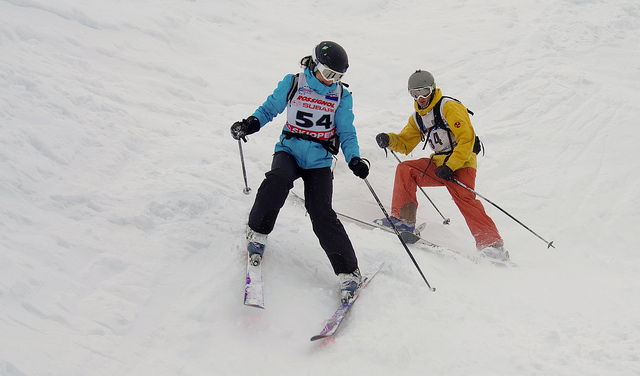

time: 140 ms (started: 2023-04-29 11:21:22 +00:00)


In [3]:
img_color = Image.open('dataset/refcocog/images/COCO_train2014_000000380440.jpg')
img_color.show()

## Using pickle in order to open .p files with text and positions of boxes

In [4]:
import pandas as pd

# Change folder name because parenthesis in filename cause problems opening it

annotations = pd.read_pickle("dataset/refcocog/annotations/refs_umd.p")
print(annotations[0])

{'image_id': 380440, 'split': 'test', 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'raw': 'the man in yellow coat', 'sent_id': 8, 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'raw': 'Skiier in red pants.', 'sent_id': 9, 'sent': 'skiier in red pants'}], 'file_name': 'COCO_train2014_000000380440_491042.jpg', 'category_id': 1, 'ann_id': 491042, 'sent_ids': [8, 9], 'ref_id': 0}
time: 2.04 s (started: 2023-04-29 11:21:22 +00:00)


## Accessing the boxes annotations in the .json file




In [5]:
import json 
from json2txttree import json2txttree
# Opening JSON file
f = open('dataset/refcocog/annotations/instances.json')
  
# returns JSON object as 
# a dictionary
boxes_data = json.load(f)

time: 7.01 s (started: 2023-04-29 11:21:24 +00:00)


### The dictionary has 5 keys: info, images, licenses, annotations, categories

*   Annotations keep a reference to the image, and the bounding box coordinates
*   Images keeps the image filename

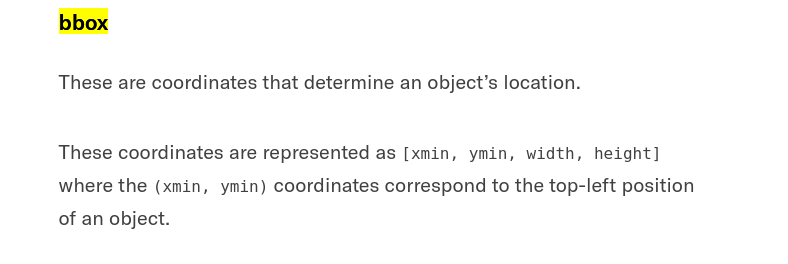

### Closing the JSON file!!

In [6]:
f.close()

time: 705 µs (started: 2023-04-29 11:21:31 +00:00)


## Tree view of the data

In [7]:
def visualise_dataset_tree():
  # Boxes data
  print(json2txttree(boxes_data))

  #plotting all the informations about the dataset
  print("#########  dataset/refcocog/annotations/refs_umd.p  #########\n")
  print(f"annotations lenght: {len(annotations)}")
  print(f"annotations type: {type(annotations)}\n")
  print(f"\telement of annotations type: {type(annotations[0])}")
  print(f"\telement of annotations: {annotations[0]}")
  print(f"\tkeys: {annotations[0].keys()}\n")
  print(f"\t\timage_id type: {type(annotations[0]['image_id'])}")
  print(f"\t\tsplit type: {type(annotations[0]['split'])}")
  print(f"\t\tsentences type: {type(annotations[0]['sentences'])}\n")
  print(f"\t\t\telement of sentences type: {type(annotations[0]['sentences'][0])}")
  print(f"\t\t\telement of sentences: {annotations[0]['sentences'][0]}")
  print(f"\t\t\tkeys: {annotations[0]['sentences'][0].keys()}\n")
  print(f"\t\t\t\ttokens type: {type(annotations[0]['sentences'][0]['tokens'])}")
  print(f"\t\t\t\traw type: {type(annotations[0]['sentences'][0]['raw'])}")
  print(f"\t\t\t\tsent_id type: {type(annotations[0]['sentences'][0]['sent_id'])}")
  print(f"\t\t\t\tsent type: {type(annotations[0]['sentences'][0]['sent'])}\n")
  print(f"\t\tfile_name type: {type(annotations[0]['file_name'])}")
  print(f"\t\tcategory_id type: {type(annotations[0]['category_id'])}")
  print(f"\t\tann_id type: {type(annotations[0]['ann_id'])}")
  print(f"\t\tsent_ids type: {type(annotations[0]['sent_ids'])}\n")
  print(f"\t\t\telement of sent_ids type: {type(annotations[0]['sent_ids'][0])}")
  print(f"\t\t\telement of sent_ids: {annotations[0]['sent_ids'][0]}\n")
  print(f"\t\tref_id type: {type(annotations[0]['ref_id'])}\n")

time: 1.51 ms (started: 2023-04-29 11:21:31 +00:00)


# Params/Hyperparams/Constants

In [8]:
BATCH_SIZE = 128
RANDOM_INDEX_IMAGE = 97
IMAGES_DIR = 'dataset/refcocog/images/'

time: 444 µs (started: 2023-04-29 11:21:31 +00:00)


# Dataclass creation

## Dataclass creation
The dataclass contains a structure such as:
* A map with image_id's as key
* For every image Id, the value is a list
* Each element of such list is a map of informations regarding bboxes and relative annotations (if any, otherwise None)
* DataLoader is still to be done

## Dict dataclass (For DataLoader purposes)
* Create a map of lists
* The keys of the map are the fields of the dataset we are interested into
* The record in each list must be ordered (index 0 in 'filename' list must correspond to index 0 in 'annotation' list

In [9]:
from torch.utils.data import Dataset, DataLoader
import random

class VGDataset(Dataset):
  def __init__(self, boxes_data : dict, annotations : list[dict], mode = 'annotated', split = 'train'):
    self.mode = mode
    self.split = split
    self.data = self.create_structure(boxes_data, annotations)
    self.clean_data = self.create_clean_structure(boxes_data, annotations)
    self.n = len(self.get_data_structure()['filename'])

    #Creates structure that is suitable for dataloader
  def create_structure(self, boxes_data, annotations):
    data = {}
    data['filename'] = []
    data['annotation'] = []
    data['box'] = []

    # Turn list of dictionaries into dictionary of list of dictionary FOR ANNOTATIONS i.e. the description text
    annotations_dict = {}
    for item in annotations:
      name = item['image_id']
      if name not in annotations_dict.keys():
        annotations_dict[name] = []
      annotations_dict[name].append(item)

    # Turn list of dictionaries into dictionary of list of dictionary FOR BOXES_ANNOTATIONS
    boxes_dict = {}
    for item in boxes_data['annotations']:
      name = item['image_id']
      if name not in boxes_dict.keys():
        boxes_dict[name] = []
      boxes_dict[name].append(item)

    # Turn list of dictionaries into dictionary of dictionary FOR BOXES_IMAGES (needed for filename)
    # Path of the image
    boxes_img_dict = {}
    for item in boxes_data['images']:
      name = item['id']
      boxes_img_dict[name] = item

    #Build the overall dataset, comprised of img id, box and annotation corresponding to the box (if there is one), and filename (similar to id but not same)
    for image_id in boxes_dict.keys():
      tmp_dict = {}
      for box in boxes_dict[image_id]:
        annotation_id = box['id']
        tmp_dict['box'] = box
        found = False
        for annotation in annotations_dict[image_id]:
          if annotation['ann_id'] == annotation_id:
            found = True
            tmp_dict['annotation'] = annotation

        if not found:
          tmp_dict['annotation'] = None

        #Getting filename from boxes_data['Images']
        tmp_dict['filename'] = IMAGES_DIR+boxes_img_dict[image_id]['file_name']

        data['filename'].append(tmp_dict['filename'])
        data['annotation'].append(tmp_dict['annotation'])
        data['box'].append(tmp_dict['box'])

    return data



#Creates structure that is suitable for dataloader (dropping boxes with no annotation)
  def create_clean_structure(self, boxes_data, annotations):
    data = {}
    data['filename'] = []
    data['annotation'] = []
    data['box'] = []

    # Turn list of dictionaries into dictionary of list of dictionary FOR ANNOTATIONS i.e. the description text
    annotations_dict = {}
    for item in annotations:
      name = item['image_id']
      if name not in annotations_dict.keys():
        annotations_dict[name] = []
      annotations_dict[name].append(item)

    # Turn list of dictionaries into dictionary of list of dictionary FOR BOXES_ANNOTATIONS
    boxes_dict = {}
    for item in boxes_data['annotations']:
      name = item['image_id']
      if name not in boxes_dict.keys():
        boxes_dict[name] = []
      boxes_dict[name].append(item)

    # Turn list of dictionaries into dictionary of dictionary FOR BOXES_IMAGES (needed for filename)
    # Path of the image
    boxes_img_dict = {}
    for item in boxes_data['images']:
      name = item['id']
      boxes_img_dict[name] = item

    #Build the overall dataset, comprised of img id, box and annotation corresponding to the box (if there is one), and filename (similar to id but not same)
    for image_id in boxes_dict.keys():
      tmp_dict = {}
      for box in boxes_dict[image_id]:
        annotation_id = box['id']
        tmp_dict['box'] = box
        found = False
        for annotation in annotations_dict[image_id]:
          if annotation['ann_id'] == annotation_id:
            if annotation['split'] == self.split:
              found = True
              tmp_dict['annotation'] = annotation

        if not found:
          tmp_dict['annotation'] = None
          continue

        #Getting filename from boxes_data['Images']
        tmp_dict['filename'] = IMAGES_DIR+boxes_img_dict[image_id]['file_name']

        data['filename'].append(tmp_dict['filename'])
        data['annotation'].append(tmp_dict['annotation'])
        data['box'].append(tmp_dict['box'])

        assert len(data['filename']) == len(data['annotation']) == len(data['box']), 'Data inconsistency'
    return data


#Returns data structure to use in the functions
  def get_data_structure(self):
    if self.mode == 'annotated':
      data_structure = self.clean_data
    elif self.mode == 'any':
      data_structure = self.data
    
    return data_structure

  #Get item for the dataloader
  def __getitem__(self, index):
    data_structure = self.get_data_structure()
    filename = data_structure['filename'][index]
    annotation = data_structure['annotation'][index]['sentences'][0]['raw']
    bbox = data_structure['box'][index]['bbox']
    return filename, annotation, torch.Tensor(bbox)

  #Get length of 
  def __len__(self):
    return self.n



time: 2.98 ms (started: 2023-04-29 11:21:31 +00:00)


### Instantiation of dict dataclass

In [10]:
train_data = VGDataset(boxes_data, annotations, 'annotated', 'train')
test_data = VGDataset(boxes_data, annotations, 'annotated', 'test')
val_data = VGDataset(boxes_data, annotations, 'annotated', 'val')

print(f"""
Len train: {len(train_data)}
Len test: {len(test_data)}
Len val: {len(val_data)}
""")

train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=True)

for batch_idx, (filenames, anns, bboxes) in enumerate(test_loader):
  for i,(filename, annotation, bbox) in tqdm(enumerate(zip(filenames, anns, bboxes))):
    ...




Len train: 42224
Len test: 5023
Len val: 2573



128it [00:00, 77092.32it/s]
128it [00:00, 620660.01it/s]
128it [00:00, 667749.89it/s]
128it [00:00, 736448.44it/s]
128it [00:00, 627919.20it/s]
128it [00:00, 747731.08it/s]
128it [00:00, 778073.79it/s]
128it [00:00, 693631.67it/s]
128it [00:00, 759364.80it/s]
128it [00:00, 764773.38it/s]
128it [00:00, 782610.66it/s]
128it [00:00, 700875.86it/s]
128it [00:00, 787200.75it/s]
128it [00:00, 795364.31it/s]
128it [00:00, 817155.12it/s]
128it [00:00, 591267.52it/s]
128it [00:00, 787200.75it/s]
128it [00:00, 748773.94it/s]
128it [00:00, 796544.38it/s]
128it [00:00, 715827.88it/s]
128it [00:00, 781471.49it/s]
128it [00:00, 654720.62it/s]
128it [00:00, 773589.21it/s]
128it [00:00, 745654.04it/s]
128it [00:00, 723545.70it/s]
128it [00:00, 655520.04it/s]
128it [00:00, 628654.46it/s]
128it [00:00, 659546.57it/s]
128it [00:00, 695428.64it/s]
128it [00:00, 700875.86it/s]
128it [00:00, 771366.25it/s]
128it [00:00, 710146.71it/s]
128it [00:00, 565127.28it/s]
128it [00:00, 628654.46it/s]
128it [00:00, 6

time: 8.06 s (started: 2023-04-29 11:21:31 +00:00)


# YOLO


## Installing YOLO


In [13]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

# Loading the small model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Available yolo classes
print(f"Available classes: {len(yolo_model.names)}")
print([values for key, values in yolo_model.names.items()])

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-29 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Available classes: 80
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
time: 19 s (started: 2023-04-29 11:21:42 +00:00)


## Computing Bboxes with YOLO
With YOLO, we can pass an image in order to get the classes of objects inside that image. 

There are 80 classes in YOLO.

In [14]:
from torch.nn.common_types import Tensor

def convert_coco_bbox_to_two_points_choords(bbox):
  if type(bbox) == Tensor:
    bbox = bbox.tolist()
  if type(bbox) == list:
    coords = [ bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3] ]
  else:
      return None
  return coords

def get_bbox_overlay(img: Image, bbox, yolo_mode: bool = False, color='red'):
  """Get a an image with an drawn bounding box overlay given coordinates.
    @param: img A PIL Image
    @param: bbox A Tensor or a List
    @param: color color of the bounding box
    @param: yolo_mode if True the coords will be kept using the COCO Dataset
    standard (x1, y1, width, height), otherwise if True they will be converted
    to (x1, y1, x2, y2) notation
    return Image
    """
  if type(bbox) == Tensor:
    print(f"Converting Tensor to list")
    bbox = bbox.tolist()
  if type(bbox) == list:
    if yolo_mode:
      # keep coco standard (x1, y1, width, height)
      coords = [(bbox[0], bbox[1]), (bbox[2], bbox[3])]
    else:
      # use width and height information to get x2, y2
      coords = convert_coco_bbox_to_two_points_choords(bbox)
    cp_img = img.copy()
    bounded_img = ImageDraw.Draw(cp_img)
    bounded_img.rectangle(coords, outline = color)
    return cp_img
  else:
    return None


time: 780 µs (started: 2023-04-29 11:22:01 +00:00)


## Visualizing COCO Dataset Bounding boxes


Converting Tensor to list


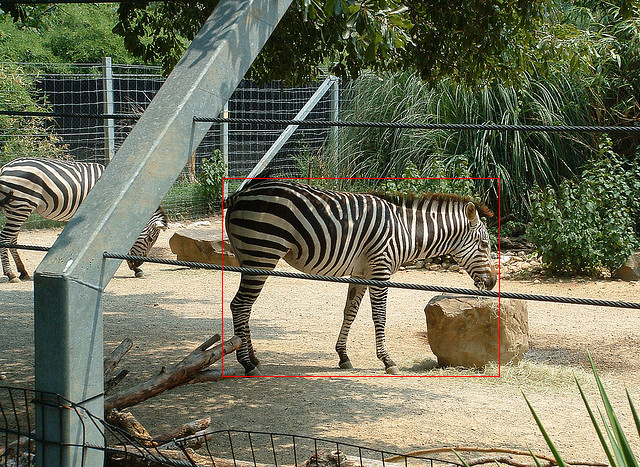

Converting Tensor to list


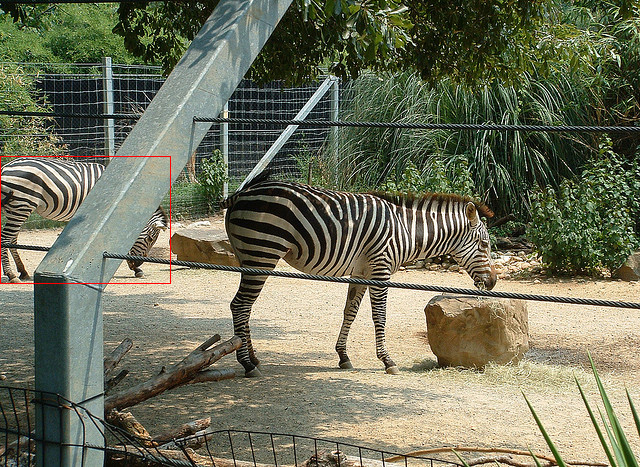

time: 1.15 s (started: 2023-04-29 11:22:01 +00:00)


In [15]:
counter = 0
for i in enumerate(train_data):
  image_str, _, bbox = train_data[counter]
  if image_str == "dataset/refcocog/images/COCO_train2014_000000262393.jpg":
    img = Image.open(image_str)
    get_bbox_overlay(img, bbox).show()
  counter += 1


In [16]:
#Batch of images (a single one in this example)
image_str, _, _ = train_data[RANDOM_INDEX_IMAGE]
print(f"Image filename: {image_str}")

#Using YOLO
results = yolo_model(image_str)
numpy_results = results.xyxy[0].detach().cpu().numpy()
results.print()
results.pandas().xyxy[0]

Image filename: dataset/refcocog/images/COCO_train2014_000000262393.jpg


image 1/1: 467x640 3 zebras
Speed: 40.8ms pre-process, 69.6ms inference, 36.5ms NMS per image at shape (1, 3, 480, 640)


xmin        ymin        xmax        ymax  confidence  class   name
0    0.000000  153.464539  107.130966  283.854584    0.827658     22  zebra
1  215.728622  181.306396  505.294434  377.747681    0.733714     22  zebra
2  121.154037  203.156174  169.347183  277.561035    0.327525     22  zebra

time: 211 ms (started: 2023-04-29 11:22:02 +00:00)


## Visualizing Yolo's bounding boxes


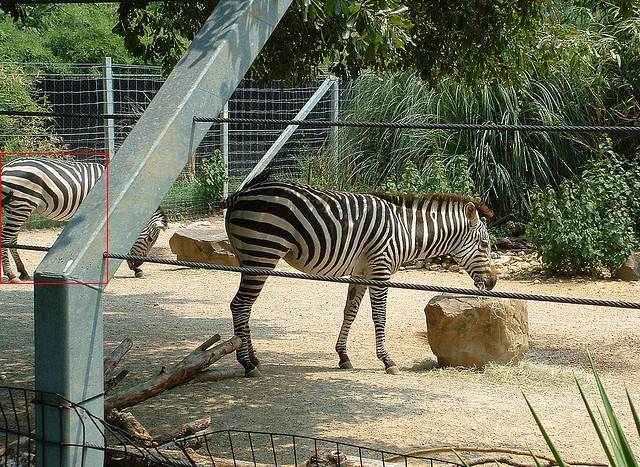

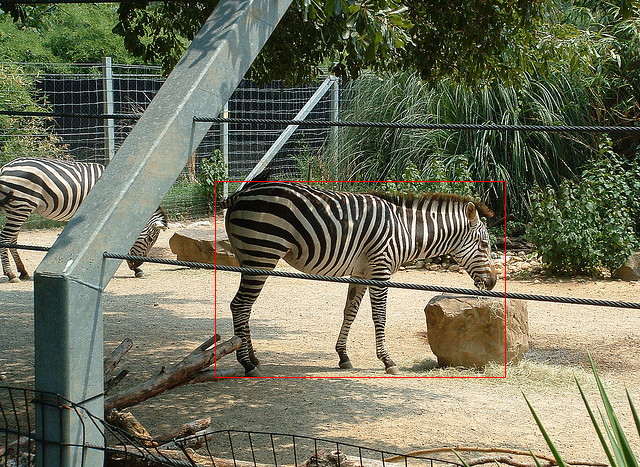

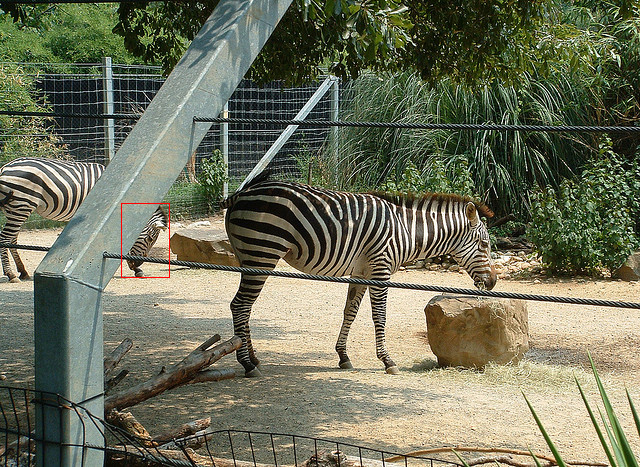

time: 325 ms (started: 2023-04-29 11:22:02 +00:00)


In [17]:
YOLO_INDEX = 0
image = Image.open(image_str)
for yolo_idx, yolo_el in enumerate(numpy_results):
  bbox =  [numpy_results[yolo_idx][0], numpy_results[yolo_idx][1], numpy_results[yolo_idx][2], numpy_results[yolo_idx][3]]
  get_bbox_overlay(image , bbox, yolo_mode=True).show()

# CLIP


## Installation

In [18]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w9xqhx_s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w9xqhx_s
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
time: 13.5 s (started: 2023-04-29 11:22:03 +00:00)


## Info about CLIP model

In [19]:
import clip
import numpy as np
print(f"Available models: {clip.available_models()}")
# Choosing RN50 following assignemt constraint:
# "Unless justified by design choices, you are constrained to use the ResNet50 version of CLIP"

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)
#preprocess is transform
clip_model, preprocess = clip.load('RN50')
if device == 'cuda':
  clip_model.cuda().eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
cuda
Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408
time: 5.83 s (started: 2023-04-29 11:22:16 +00:00)


## Evaluating bounding boxes with CLIP: IDEA
* Cropping the bounding boxes predicted by YOLO
* preprocessing of an image annotation
* preprocessing of cropped images
* compute cosine similarity between the encoding of each image and the encoding of the annotation


In [20]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 6.76 s (started: 2023-04-29 11:22:22 +00:00)


### Evaluation: Cosine similarity

In [21]:
#Takes two tensors as input
def get_cosine_similarity_matrix(image_feature_matrix : Tensor, annotation_encoding : Tensor):
  #Normalization step
  annotation_encoding /= annotation_encoding.float().norm(dim=-1, keepdim=True)
  image_feature_matrix /= image_feature_matrix.float().norm(dim=-1, keepdim=True)

  #Computing the similarity
  similarity = (annotation_encoding @ image_feature_matrix.T)
  return similarity #.cpu() doesn't work

def get_cosine_similarity_probability(image_feature_matrix : Tensor, annotation_encoding : Tensor):
  similarity_matrix = get_cosine_similarity_matrix(tensor_images_features, text_features)
  # Probability for each bounding box
  similarity_probability = ((100.0 * similarity_matrix).softmax(dim=-1))
  # print(f"Similarity matrix {similarity_matrix}")
  # print(f"Max similarity probability value: {values[0]}")
  return similarity_probability 

def get_max_cosine_probability(cosine_probability_tensor : Tensor):
  """
  return indeces and values for the topk(1) of the tensor
  """
  return cosine_probability_tensor.topk(1)

time: 925 µs (started: 2023-04-29 11:22:29 +00:00)


## Evaluation: Euclidean Distance

In [22]:
from torchmetrics.functional import pairwise_euclidean_distance

def get_euclidean_distance_matrix(image_feature_matrix : Tensor, annotation_encoding : Tensor):
  return pairwise_euclidean_distance(image_feature_matrix, annotation_encoding)

time: 291 ms (started: 2023-04-29 11:22:29 +00:00)


### Evaluation: Intersection over Union

In [23]:
def get_IoU(predicted_bbox : list, gold_bbox: list ):
  """ We assume that the box follows the format:
		box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
		where (x1,y1) and (x3,y3) represent the top left coordinate,
		and (x2,y2) and (x4,y4) represent the bottom right coordinate """
  #
  #It is working now, but
  #The computed area of the gold_bbox is different with respect to
  #the one present in the dataset
  #I've seen this only in 1/1 photo, maybe it is a dataset problem, idk
  #
  #Is it symmetric? YES IT IS
  x1, y1, x2, y2 = predicted_bbox	
  x3, y3, x4, y4 = gold_bbox
  x_inter1 = max(x1, x3)
  y_inter1 = max(y1, y3)
  x_inter2 = min(x2, x4)
  y_inter2 = min(y2, y4)
  area_inter = abs(max((x_inter2 - x_inter1, 0)) * max((y_inter2 - y_inter1), 0))
  width_box1 = abs(x2 - x1)
  height_box1 = abs(y2 - y1)
  width_box2 = abs(x4 - x3)
  height_box2 = abs(y4 - y3)
  area_box1 = width_box1 * height_box1
  area_box2 = width_box2 * height_box2
  area_union = area_box1 + area_box2 - area_inter
  iou = area_inter / area_union
  return iou  


time: 17.9 ms (started: 2023-04-29 11:22:29 +00:00)


### Evaluation: Recall

In [24]:
# It will be implemented for the solution that will beat the baseline

time: 247 µs (started: 2023-04-29 11:22:29 +00:00)


### Computing cosine similarity between the cropped images and the gold annotation

In [25]:
#bbox and annotation to be used from now on
el_filename, el_annotation, el_bbox = train_data[RANDOM_INDEX_IMAGE]
print(el_filename)
print(el_annotation)
print(el_bbox)

dataset/refcocog/images/COCO_train2014_000000262393.jpg
A zebra in the zoo, smelling the stone
tensor([222.53000, 178.75000, 276.85999, 197.46001])
time: 35.5 ms (started: 2023-04-29 11:22:29 +00:00)


In [26]:
def show_cropped_images(cropped_images):
  for i in range(len(cropped_images)):
    cropped_images[i].show()

time: 536 µs (started: 2023-04-29 11:22:29 +00:00)


Sentence obtained from image with index 97: A zebra in the zoo, smelling the stone
Showing again yolo predicted bounding boxes


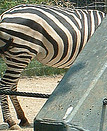

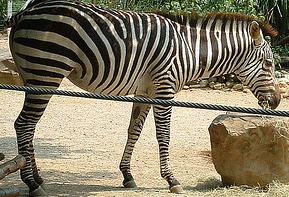

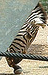

tensor(1.20020, device='cuda:0', dtype=torch.float16)
time: 500 ms (started: 2023-04-29 11:22:29 +00:00)


In [27]:
image = Image.open(el_filename)
cropped_images = []

for bbox in numpy_results:
  cropped_images.append(image.crop((bbox[0], bbox[1], bbox[2], bbox[3])))

# Annotation of the desired bounding box (cropped image)
# !!!
# WATCH OUT: We are currently getting a random annotation
# The accuracy result is replicable ONLY IF there is one annotation for the img
# !!!
# NOTE: the accuracy is to be computed over a batch of the dataset (taking the average for example)
raw_sentence = el_annotation
print(f"Sentence obtained from image with index {RANDOM_INDEX_IMAGE}: {raw_sentence}")

# Text encoding
text_inputs = torch.cat([clip.tokenize(raw_sentence)]).to(device)
# Clip Embedding dimension for text input (RESNET50) -> text_features.shape == 1024
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)

# Images encoding
images_features = []
for img in cropped_images:
  image_input = preprocess(img).unsqueeze(0).to(device)
  # Clip Embedding dimension for image input (RESNET50) -> image_features.shape == 1024
  with torch.no_grad():
    images_features.append(clip_model.encode_image(image_input.detach().clone()))

print("Showing again yolo predicted bounding boxes")
show_cropped_images(cropped_images)

#Bringing list of images into a tensor
tensor_images_features = torch.stack(images_features).squeeze(1)

#Getting cosine similarity probability (one value for each bounding box)
cosine_similarity_probability = get_cosine_similarity_probability(tensor_images_features,text_features)
_, best_bbox_indx = get_max_cosine_probability(cosine_similarity_probability)
# Getting euclidean distance
euclidean_dist_matrix = get_euclidean_distance_matrix(tensor_images_features,text_features)
print(torch.min(euclidean_dist_matrix))

### Computing Intersection over Union (IoU)

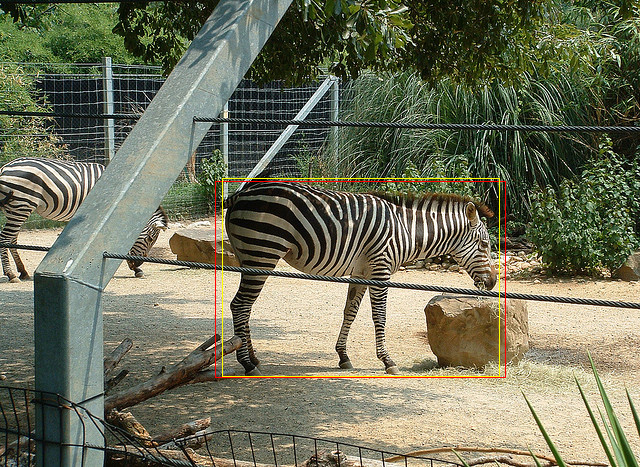

Gold bbox: [222.52999877929688, 178.75, 499.3899841308594, 376.2100067138672] and predicted bbox: [215.72862, 181.3064, 505.29443, 377.74768]
The IoU value is 0.9369786196827365
time: 132 ms (started: 2023-04-29 11:22:30 +00:00)


In [28]:
#Recollect bounding box on best crop from index
predicted_bbox = [numpy_results[best_bbox_indx][0], numpy_results[best_bbox_indx][1], numpy_results[best_bbox_indx][2], numpy_results[best_bbox_indx][3]]

#Extract gold bbox
bbox = el_bbox.tolist()
gold_bbox = convert_coco_bbox_to_two_points_choords(bbox) 

# Show best bbox given cosine similarity
overlay = get_bbox_overlay(image, predicted_bbox, yolo_mode=True)
get_bbox_overlay(overlay, gold_bbox, yolo_mode = True, color='yellow').show()

#Compute intersection over union
iou = get_IoU(predicted_bbox, gold_bbox)

print(f"Gold bbox: {gold_bbox} and predicted bbox: {predicted_bbox}")
print(f"The IoU value is {iou}")

# Putting everything together (batch)

In [ ]:
iou_results = []
for batch_idx, (filenames, anns, bboxes) in enumerate(test_loader):
  for i,(filename, annotation, bbox) in enumerate(zip(filenames, anns, bboxes)):
    result = yolo_model(filename)
    numpy_result = result.xyxy[0].detach().cpu().numpy()

  #Case where YOLO couldn't find any bounding box
    if len(numpy_result) == 0:
      iou_results.append(0)
      continue
    
    image = Image.open(filename)
    gold_bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]


    #Using CLIP to find best crop
    #Computing crops
    croppings = []
    for bbox in numpy_result:
      croppings.append(image.crop((bbox[0], bbox[1], bbox[2], bbox[3])))

    # Encoding text
    text_inputs = torch.cat([clip.tokenize(annotation)]).to(device)
    with torch.no_grad():
      text_features = clip_model.encode_text(text_inputs)

    # Encoding image crops
    images_features = []
    #No need of for loop here 
    for img in croppings:
      image_input = preprocess(img).unsqueeze(0).to(device)
      with torch.no_grad():
        images_features.append(clip_model.encode_image(image_input.detach().clone()))

    #Bringing list of images into a tensor
    tensor_images_features = torch.stack(images_features).squeeze(1)

    #Getting cosine similarity probability (one value for each bounding box)
    cosine_similarity_probability = get_cosine_similarity_probability(tensor_images_features,text_features)
    _, best_bbox_indx = get_max_cosine_probability(cosine_similarity_probability)
    
    #Evaluating with IoU
    predicted_bbox = [numpy_result[best_bbox_indx][0], numpy_result[best_bbox_indx][1], numpy_result[best_bbox_indx][2], numpy_result[best_bbox_indx][3]]
    iou = get_IoU(predicted_bbox, gold_bbox)
    #print(f"Now evaluating image {i}/{BATCH_SIZE} of batch {batch_idx} \t Best crop is number {best_bbox_indx} \t and its iou is {iou}")
    iou_results.append(iou)

#Computing the mean of IoU
print(f"\nMean intersection over unit {np.mean(iou_results)}")



STOP

STOP

# Zero shot object detection
link: https://www.youtube.com/watch?v=i3OYlaoj-BM

In [ ]:
image_zero_shot = Image.open('dataset/refcocog/images/'+Custom_dataset.img_rep[110][0]['filename'])
image_zero_shot.show()
#Custom_dataset.img_rep[127][1]['filename']

In [ ]:
from torchvision import transforms

transform = transforms.ToTensor()

img = transform(image_zero_shot)
img.data.shape

In [ ]:
patches = img.data.unfold(0,3,3)
patches.shape

In [ ]:
patch = 64
patches = patches.unfold(1, patch, patch)
patches.shape

In [ ]:
patches = patches.unfold(2, patch, patch)
patches.shape

In [ ]:
import matplotlib.pyplot as plt

X = patches.shape[1]
Y = patches.shape[2]

fig, ax = plt.subplots(X, Y, figsize=(Y*2, X*2))
for x in range(X):
  for y in range(Y):
    ax[x, y].imshow(patches[0,x,y].permute(1,2,0))
    ax[x, y].axis('off')
fig.tight_layout()
plt.show()